Contoh Soal REGRESSION TREES

In [ ]:
import pandas as pd
import numpy as np

# Memasukkan keseluruhan data olahan
data_olahan = {
    'Temperatur': [80, 83, 68, 64, 69, 71, 78, 82, 73, 77],
    'Kelembapan': [90, 78, 80, 65, 70, 80, 75, 92, 88, 70],
    'Jumlah_Pemain': [39, 43, 28, 43, 56, 13, 51, 41, 29, 36]
}
df = pd.DataFrame(data_olahan)

# Menampilkan data olahan dalam bentuk tubular
display(df)

# Melihat informasi dasar dari keseluruhan data olahan
df.info()

,Temperatur,Kelembapan,Jumlah_Pemain
0,80,90,39
1,83,78,43
2,68,80,28
3,64,65,43
4,69,70,56
5,71,80,13
6,78,75,51
7,82,92,41
8,73,88,29
9,77,70,36


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Temperatur     10 non-null     int64
 1   Kelembapan     10 non-null     int64
 2   Jumlah_Pemain  10 non-null     int64
dtypes: int64(3)
memory usage: 368.0 bytes


In [4]:
from sklearn.model_selection import train_test_split

# Penetapan variabel input dan variabel output
X, y = df.drop('Jumlah_Pemain', axis=1), df['Jumlah_Pemain']

# Splitting data olahan menjadi data latih dan data uji dengan perbandingan proporsi data 50%:50%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, shuffle=False)

# Menampilkan seluruh sampel data dari data latih dan data uji, sesuai variabelnya.
display(X_train, y_train)
display(X_test, y_test)

,Temperatur,Kelembapan
0,80,90
1,83,78
2,68,80
3,64,65
4,69,70


0    39
1    43
2    28
3    43
4    56
Name: Jumlah_Pemain, dtype: int64

,Temperatur,Kelembapan
5,71,80
6,78,75
7,82,92
8,73,88
9,77,70


5    13
6    51
7    41
8    29
9    36
Name: Jumlah_Pemain, dtype: int64

In [5]:
# Mendefinisikan fungsi pemisahan simpul secara greedy
def evaluate_all_splits(X_train, y_train):
    """Mengevaluasi Seluruh Kandidat Pemisah pada Simpul"""
    results = []
    
    for feature in X_train.columns:
        data = pd.DataFrame({'feature': X_train[feature], 'y_actual': y_train})
        titik_pemisahan = [(a + b)/2 for a, b in zip(sorted(data['feature'].unique())[:-1], sorted(data['feature'].unique())[1:])]
        
        for split in titik_pemisahan:
            subset_kiri = data['feature'] <= split
            jumlah_data_subset_kiri = sum(subset_kiri)
            
            if not (0 < jumlah_data_subset_kiri < len(data)): continue
                
            rerataan_subset_kiri = data[subset_kiri]['y_actual'].mean()
            rerataan_subset_kanan = data[~subset_kiri]['y_actual'].mean()
            
            kemurnian_subset_kiri = ((data[subset_kiri]['y_actual'] - rerataan_subset_kiri) ** 2).mean()
            kemurnian_subset_kanan = ((data[~subset_kiri]['y_actual'] - rerataan_subset_kanan) ** 2).mean()
            
            kualitas_kandidat_pemisah = (jumlah_data_subset_kiri * kemurnian_subset_kiri + (len(data) - jumlah_data_subset_kiri) * kemurnian_subset_kanan) / len(data)
            
            results.append({'Variabel Input': feature, 'Titik Pemisahan': split, 'Kualitas Kandidat Pemisah': kualitas_kandidat_pemisah})
    
    return pd.DataFrame(results).round(2)

# Contoh Penggunaan fungsi pemisahan simpul
results = evaluate_all_splits(X_train, y_train)
print(results)

  Variabel Input  Titik Pemisahan  Kualitas Kandidat Pemisah
0     Temperatur             66.0                      80.20
1     Temperatur             68.5                      54.10
2     Temperatur             74.5                      80.13
3     Temperatur             81.5                      80.20
4     Kelembapan             67.5                      80.20
5     Kelembapan             74.0                      41.03
6     Kelembapan             79.0                      34.63
7     Kelembapan             85.0                      78.60


In [6]:
# Mendefinisikan Fungsi Pencarian Nilai dari Kualitas Kandidat Pemisah
def calculate_split_mse(X_train, y_train, feature_name, split_point):
    
    # Mendefinisi data latih berdasarkan urutan variabel input
    datalatih_df = pd.DataFrame({
        'x_latih': X_train[feature_name],
        'y_latih': y_train
    }).sort_values('x_latih')
    
    # Mendefinisikan subset kiri dan kanan sesuai titik pemisahan
    subset_kiri = datalatih_df['x_latih'] <= split_point
    rerataan_subset_kiri = datalatih_df[subset_kiri]['y_latih'].mean()
    rerataan_subset_kanan = datalatih_df[~subset_kiri]['y_latih'].mean()
    
    # Perhitungan kuadrat dari selisih sampel data x_latih dan y_latih
    datalatih_df['squared_diff'] = np.where(
        subset_kiri,
        (datalatih_df['y_latih'] - rerataan_subset_kiri) ** 2,
        (datalatih_df['y_latih'] - rerataan_subset_kanan) ** 2
    )
    
    # Perhitungan kriteria kemurnian dari subset kiri dan subset kanan
    kemurnian_subset_kiri = datalatih_df[subset_kiri]['squared_diff'].mean()
    kemurnian_subset_kanan = datalatih_df[~subset_kiri]['squared_diff'].mean()
    jumlah_data_subset_kiri = sum(subset_kiri)
    jumlah_data_subset_kanan = len(datalatih_df) - jumlah_data_subset_kiri
    
    # Perhitungan kualitas kandidat pemisah
    kualitas_kandidat_pemisah = (jumlah_data_subset_kiri * kemurnian_subset_kiri + jumlah_data_subset_kanan * kemurnian_subset_kanan) / len(datalatih_df)
    
    # Print hasil funngsi greedy
    display(datalatih_df)
    print(f"\nHasil dari pemisahan data latih pada (Titik Pemisahan={split_point}) dalam (Variabel Input: {feature_name}):")
    print(f"Kemurnian Subset Kiri (Jumlah data subset kiri={jumlah_data_subset_kiri}, Rerataan={rerataan_subset_kiri:.2f}): {kemurnian_subset_kiri:.2f}")
    print(f"Kemurnian Subset Kanan (Jumlah data subset kanan={jumlah_data_subset_kanan}, Rerataan={rerataan_subset_kanan:.2f}): {kemurnian_subset_kanan:.2f}")
    print(f"Kualitas Kandidat Pemisah: {kualitas_kandidat_pemisah:.2f}")

# Contoh penggunaan fungsi greedy pada kandidat pemisah yang ditinjau
calculate_split_mse(X_train, y_train, 'Temperatur', 66)

,x_latih,y_latih,squared_diff
3,64,43,0.00
2,68,28,182.25
4,69,56,210.25
0,80,39,6.25
1,83,43,2.25



Hasil dari pemisahan data latih pada (Titik Pemisahan=66) dalam (Variabel Input: Temperatur):
Kemurnian Subset Kiri (Jumlah data subset kiri=1, Rerataan=43.00): 0.00
Kemurnian Subset Kanan (Jumlah data subset kanan=4, Rerataan=41.50): 100.25
Kualitas Kandidat Pemisah: 80.20


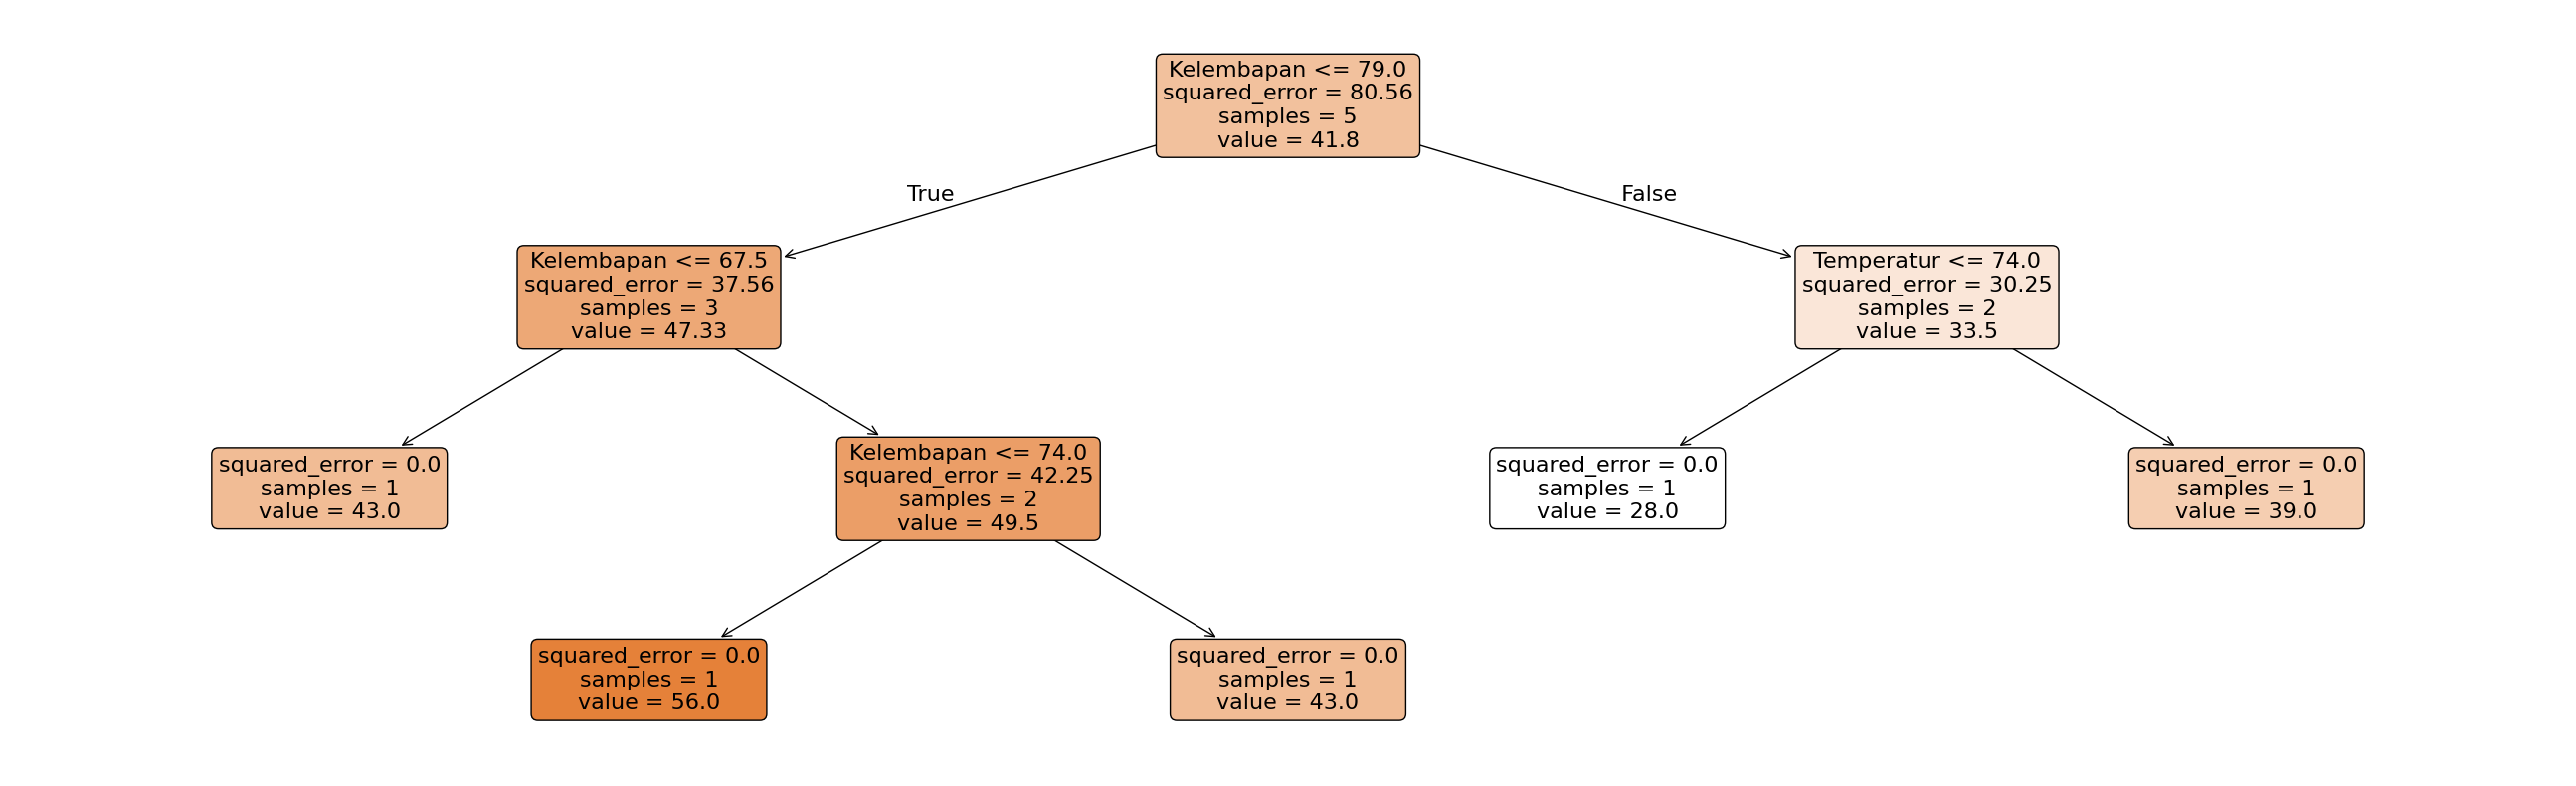

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Melatih Model Regression Tree
RegressionTree = DecisionTreeRegressor(random_state=42)
RegressionTree.fit(X_train, y_train)

# Visualisasi Regression Tree yang Terbentuk
plt.figure(figsize=(26,8))
plot_tree(RegressionTree, feature_names=X.columns, filled=True, rounded=True, impurity=True, fontsize=16, precision=2)
plt.tight_layout()
plt.show()

In [8]:
# Memperlihatkan hasil regresi
y_pred = RegressionTree.predict(X_test)
print(y_pred)

[28. 43. 39. 28. 56.]


,Prediksi,Aktual
5,28.0,13
6,43.0,51
7,39.0,41
8,28.0,29
9,56.0,36


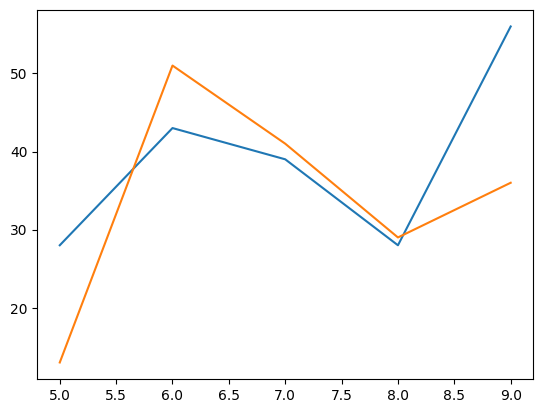

In [ ]:
def plot_predictions(RegressionTree, X, y):
    predictions = RegressionTree.predict(X_test)
    df = pd.DataFrame(data={'Prediksi': predictions, 'Aktual': y})
    plt.plot(df['Prediksi'])
    plt.plot(df['Aktual'])
    return df

plot_predictions(RegressionTree, X_test, y_test)

In [ ]:
from sklearn.metrics import root_mean_squared_error

# Evaluasi kinerja model dengan metrik RMSE
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse:.4f}')

RMSE: 11.7813
